In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import random as rd
import sys

sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import PerturbedPendulum_Methods as pp

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
x, y = pp.read_dataset('x_train.txt', 'y_train.txt')
len(x)

100000

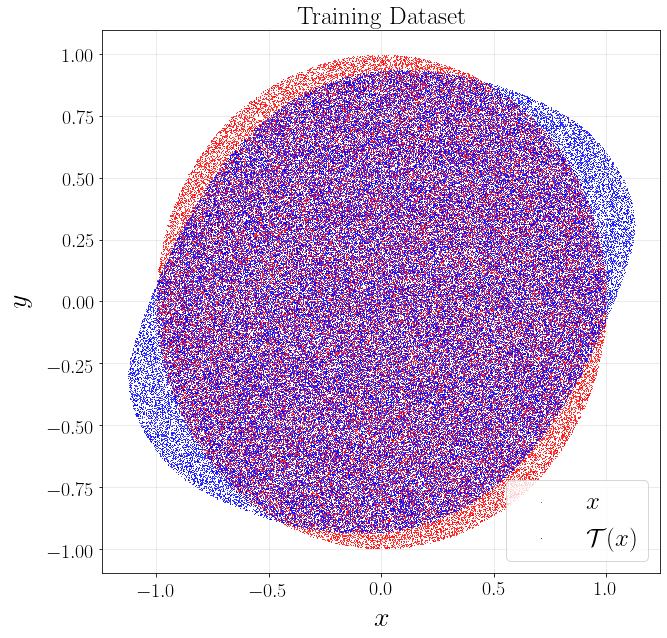

In [3]:
pp.plot_dataset(x, y)

In [4]:
train_dataset, val_dataset = pp.train_dataset(x, y, 10000, 50000, 10000) #val_len, train_batch, val_batch

In [5]:
class MLP(tf.keras.layers.Layer):
    
    def __init__(self):
        super(MLP, self).__init__()

    def build(self, input_shape):
        
        self.L1 = tf.keras.layers.Dense(3, activation='tanh')
        self.L2 = tf.keras.layers.Dense(3, activation='tanh')
        self.L3 = tf.keras.layers.Dense(2, activation='tanh')


    def call(self, inputs, training=False):
        
        h = self.L1(inputs)
        h = self.L2(h)
        h = self.L3(h)
        
        return h

In [6]:
class shift(tf.keras.layers.Layer):
    
    def __init__(self):

        super(shift, self).__init__()

    def build(self, input_shape):
        
        self.w = self.add_weight(
            name='w',
            shape=(2,),
            initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
            trainable = True
            )
            
        self.b = self.add_weight(
            name='b',
            shape=(2,),
            initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
            trainable = True
            )


    def call(self, inputs, training=False):
        
        return self.w*inputs + self.b

In [7]:
def get_shift_and_log_scale_resnet(input_shape, blocks, shift):
    
    inputs = tf.keras.Input(shape=input_shape)
    h = inputs

    for block in blocks:
        h = block(h)

    shift, log_scale = shift(inputs), h
    log_scale = tf.math.tanh(log_scale)
    return Model(inputs=inputs, outputs=[shift, log_scale], name='name')

In [8]:
class AffineCouplingLayer(layers.Layer):

    def __init__(self, shift_and_log_scale_fn, mask):
        
        super(AffineCouplingLayer, self).__init__()
        self.shift_and_log_scale_fn = shift_and_log_scale_fn
        self.b = tf.cast(mask, tf.float32)

    def call(self, x, inverse):
        
        if inverse == 1:
            t, log_s = self.shift_and_log_scale_fn(x * self.b)
            y = self.b * x + (1 - self.b) * (x * tf.exp(log_s) + t)
            return y
        
        if inverse == 0:
            t, log_s = self.shift_and_log_scale_fn(x * self.b)
            y = self.b * x + (1 - self.b) * ((x - t) * tf.exp(-log_s))
            return y

In [9]:
class R(tf.keras.layers.Layer):

    def __init__(self):
        super(R, self).__init__()
        
    def call(self, inputs):
        return inputs*tf.constant([[1., -1.]])

In [10]:
class RealNVPModel(tf.keras.Model):
    
    def __init__(self, shift_and_log_scale, **kwargs):
        
        super(RealNVPModel, self).__init__()
        self.R = R()
        masks = []
        self.l = []
        
        for j in range(len(shift_and_log_scale)):
            
            if j%2==0:
                masks.append(tf.constant([[0., 1.]]))
            else:
                masks.append(tf.constant([[1., 0.]]))

        
        for i,j in zip(shift_and_log_scale, masks):
            self.l.append(AffineCouplingLayer(i, j))
        

    def call(self, input_tensor):
        
        a = self.R(input_tensor)
        
        for layer in self.l:
            a = layer(a, 1)

        a = self.R(a)

        for layer in self.l[::-1]:
            a = layer(a, 0)
        
        return a

In [11]:
num_blocks = 4

blocks = [MLP() for i in range(num_blocks)]

shifts = [MLP() for i in range(len(blocks))]

shift_and_log_scale = [get_shift_and_log_scale_resnet((2), [i], j) for i,j in zip(blocks, shifts)]

In [12]:
shift_and_log_scale[0].summary()

Model: "name"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
mlp (MLP)                       (None, 2)            29          input_1[0][0]                    
__________________________________________________________________________________________________
mlp_4 (MLP)                     (None, 2)            29          input_1[0][0]                    
__________________________________________________________________________________________________
tf.math.tanh (TFOpLambda)       (None, 2)            0           mlp[0][0]                        
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________

In [13]:
model = RealNVPModel(shift_and_log_scale)

In [14]:
# DECAYING LEARNING RATE
def scheduler(epoch, lr):
    if epoch < 5:
        print(lr)
        return lr
    else:
        #print(lr)
        return lr*tf.math.exp(-0.0002)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

0.002
0.002
0.002
0.002
0.002


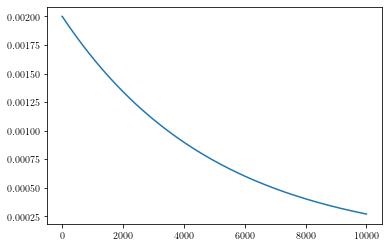

In [15]:
lr = [0.002]
for i in range(10000):
    lr.append(scheduler(i, lr[-1]))

plt.plot(lr)
plt.show()

In [16]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #loss = custom_loss,
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=tf.keras.optimizers.Adam(0.002), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [17]:
history = model.fit(train_dataset, epochs = 100, callbacks = [callback], verbose=1) #np.array(x), [np.array(y),a,a]

Epoch 1/100
0.0020000000949949026
2/2 [==============================] - 4s 518ms/step - loss: 2.2252 - accuracy: 0.4813
Epoch 2/100
0.0020000000949949026
2/2 [==============================] - 1s 454ms/step - loss: 2.0066 - accuracy: 0.4684
Epoch 3/100
0.0020000000949949026
2/2 [==============================] - 1s 461ms/step - loss: 1.8159 - accuracy: 0.4543
Epoch 4/100
0.0020000000949949026
2/2 [==============================] - 1s 469ms/step - loss: 1.6494 - accuracy: 0.4394
Epoch 5/100
0.0020000000949949026
2/2 [==============================] - 1s 473ms/step - loss: 1.5036 - accuracy: 0.4264
Epoch 6/100
2/2 [==============================] - 1s 462ms/step - loss: 1.3752 - accuracy: 0.4143
Epoch 7/100
2/2 [==============================] - 1s 468ms/step - loss: 1.2614 - accuracy: 0.4053
Epoch 8/100
2/2 [==============================] - 1s 459ms/step - loss: 1.1599 - accuracy: 0.3990
Epoch 9/100
2/2 [==============================] - 1s 459ms/step - loss: 1.0687 - accuracy: 0.3953

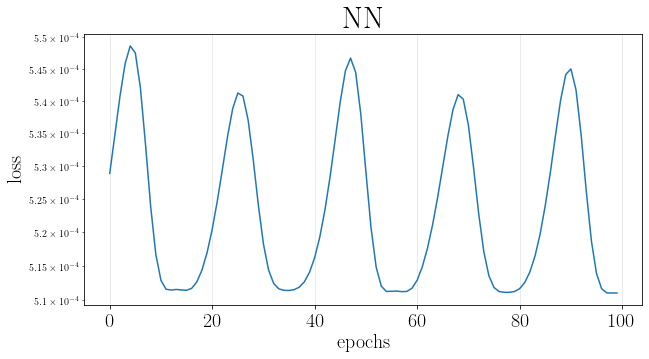

In [196]:
plt.figure(figsize = (10,5))
#plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'NN', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

In [214]:
x0 = np.array([[rd.randrange(-500, 500, 1)*0.001, rd.randrange(-500, 500, 1)*0.001] for _ in range(500)])

f_iterations = [model(x0)]

In [215]:
for _ in range(100):
    f_iterations.append(model(f_iterations[-1]))

b_iterations = [f_iterations[-1]*np.array([[1., -1.]])]

for _ in range(100):
    b_iterations.append(model(b_iterations[-1]))

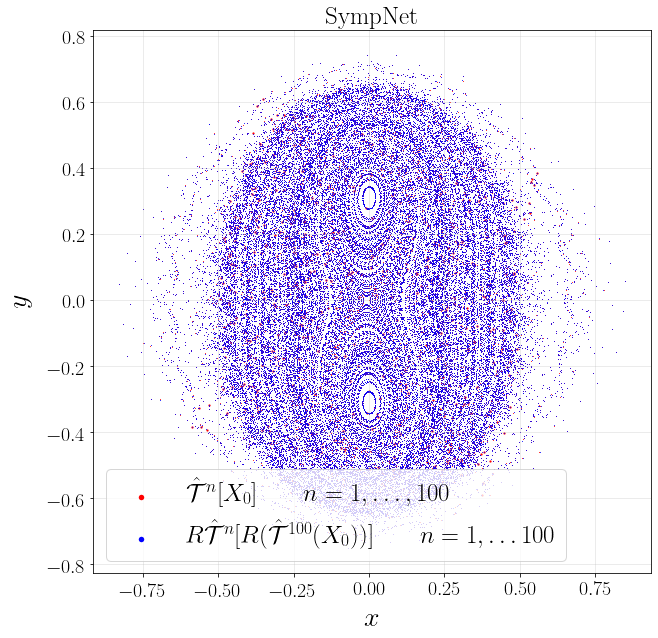

In [216]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'SympNet', fontsize = 25)


plt.scatter(*zip(*f_iterations[0].numpy()), s=5, linewidth=0, color='r', label= r'$\hat{\mathcal{T}}^{n}[X_{0}] \qquad n=1,\dots ,100$')

for i in f_iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0, color='r')
    
#plt.scatter(*zip(*f_iterations[-1].numpy()), s=15, linewidth=0, color='r')

#plt.scatter(*zip(*b_iterations[0].numpy()), s=15, linewidth=0, color='b')

b_iterations_symm = b_iterations*np.array([[1., -1.]])

plt.scatter(*zip(*b_iterations_symm[0]), s=1, linewidth=0, color='b', label= r'$R \hat{\mathcal{T}}^{n}[R(\hat{\mathcal{T}}^{100}(X_{0}))] \qquad n=1,\dots 100$')

for i in b_iterations_symm:
    plt.scatter(*zip(*i), s=1, linewidth=0, color='b')

plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
lgnd = plt.legend(scatterpoints=1, fontsize=25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
#plt.savefig("Testing_Reversinility_NonReversible.png")
plt.show()